This notebook explores how to expires assets in an experiment after a certain date.

First, we will make sure we have all of the necessary Python modules:

In [1]:
%pip install -U "comet_ml>=3.44.0" aitk.utils Pillow

Note: you may need to restart the kernel to use updated packages.


Next, we import all of the modules we will need:

In [2]:
# Import Python modules:
import random
import os
import glob
import urllib
import zipfile
import datetime
import random
import json

# Additional modules:
from PIL import Image
from aitk.utils import gallery
import comet_ml

For this demo, we'll create some fun images. First we need to download them, so we write a general download and unzip function:

In [3]:
def download(url, filename=None):
    filename = filename if filename is not None else os.path.basename(url)
    basename, ext = os.path.splitext(filename)
    g = urllib.request.urlopen(url, timeout=5)
    with open(filename, "wb") as f:
        f.write(g.read())
    if ext == ".zip":
        with zipfile.ZipFile(filename, "r") as zip_ref:
            zip_ref.extractall(basename)

And we download a dataset of image parts. These are based on the images and code from:

https://github.com/pixegami/pixel-punk-avatars

In [23]:
download("https://github.com/dsblank/pixel-punk-avatars/raw/main/images/images.zip")

We should now have a directory called "images" that contains faces, eyes, hair, and accessories.

Now, we make sure that we have our Comet API key set:

In [5]:
comet_ml.login()

We write a simple image generation function:

In [24]:
def generate_image():
    bg_color = random.choice([(120, 150, 180), (255, 225, 150)])
    image = Image.new("RGBA", (24, 24), bg_color)
    for layer, probability in [
        ("0_face", 1.0),
        ("1_eye", 1.0),
        ("2_hair", 0.8),
        ("3_accessory", 0.15),
    ]:
        if random.random() > probability:
            continue
        items = glob.glob(f"images/{layer}/*.png")
        layer_image = Image.open(random.choice(items))
        image = Image.alpha_composite(image, layer_image)
    return image

Every time we call it, we get a different image:

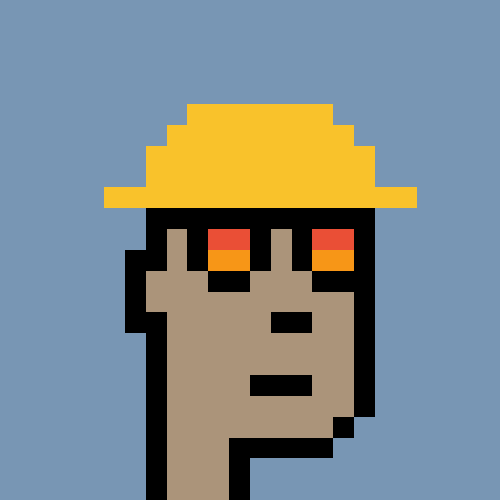

In [25]:
image = generate_image()
image.resize((500, 500), resample=Image.Resampling.NEAREST)

Now, let's call it 625 times to generate a nice dataset:

In [26]:
images = [generate_image() for i in range(625)]

A nice function from `aitk.utils` is the `gallery()` function that generates a gallery of images from a list of images:

In [27]:
gallery(images)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124
125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174
175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224
225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274


Now, we create an experiment to log all of the images.

In [10]:
experiment = comet_ml.start(project_name="pixel-punk-avatars")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/dsblank/comet/examples' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dsblank/pixel-punk-avatars/49d4079aa31243d69e7d3166b3255c79



We'll need some support functions to help us:

In [11]:
def random_day(n=100):
    """
    Return a random day n days in the future.
    """
    today = datetime.date.today()
    return add_days(today, random.randint(1, n))


def add_days(day, n):
    """
    Method to do some date math.
    """
    return day + datetime.timedelta(days=n)


def day_to_timestamp(day):
    """
    Turn a day into an integer timestamp
    """
    date = datetime.datetime(day.year, day.month, day.day)
    return date.timestamp()


def timestamp_to_day(timestamp):
    """
    Turn a timestamp into a day
    """
    return datetime.datetime.fromtimestamp(timestamp)

The reason for the timestamp is that we can't log an experation day directly, but need to encode it as a number.

Now we log each image, storing the date to expire in the metadata of the image. Note that for this demo we create random dates between 1 and 100 days in the future.

In [12]:
for image in images:
    experiment.log_image(image, metadata={"expires_on": day_to_timestamp(random_day())})

and call `experiment.end()` because we are in a Jupyter Notebook.

In [13]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/dsblank/pixel-punk-avatars/49d4079aa31243d69e7d3166b3255c79
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     images                       : 625
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages                  : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET INFO: Please wait for assets to finish upl

We can check to see that the images were loaded by examining the Graphics tab in the Come UI:

In [30]:
experiment.display(tab="graphics")

Now we are ready to expire those images past a certain date. We'll use the Comet API to get the assets.

In [14]:
api = comet_ml.API()

We write a function to delete the image assets given an experiment key (id) and date:

In [31]:
def delete_experiment_assets(experiment_key, expires_on):
    api_experiment = api.get_experiment_by_key(experiment_key)
    count = 0
    for asset_data in api_experiment.get_asset_list():
        if asset_data["type"] == "image":
            asset_metadata = json.loads(asset_data["metadata"])
            asset_id = asset_data["assetId"]
            timestamp = asset_metadata["expires_on"]
            if timestamp > expires_on:
                print(f"Deleting {asset_id}")
                api_experiment.delete_asset(asset_id)
                count += 1
    print(f"{count} assets expired")

For this demo, let's pick a day 90 days in the future:

In [21]:
# A date 90 days in the future:
expires_on = day_to_timestamp(add_days(datetime.date.today(), 90))

And now, we simply call the function given the experiment.id from above, and the date 90 days from now:

In [22]:
delete_experiment_assets(experiment.id, expires_on)

70 assets expired


That should have deleted about 10% of the 625 images, or about 62 images give or take.

If you run the `delete_experiment_assets()` again with the same arguments, it shouldn't delete any assets.

In [ ]:
delete_experiment_assets(experiment.id, expires_on)

Now, every once in a while you can call `delete_experiment_assets()` with a paticular date, and you'll delete all of the assets that should be "expired".